<a href="https://colab.research.google.com/github/ariahosseini/TradML/blob/main/SciKitLearn_06_ProjSix_Supervised_Reg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.io

from sklearn import linear_model
from sklearn import metrics
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.cross_decomposition import PLSRegression

import sys
import sklearn
print(sys.version)
!python --version
print("numpy: ", np.__version__)
print("sklearn: ", sklearn.__version__)

!pip install openpyxl

3.11.4 (main, Jul  5 2023, 08:41:25) [Clang 14.0.6 ]
Python 3.11.4
numpy:  1.23.5
sklearn:  1.2.2


In [ ]:
path = './'
mmc3 = scipy.io.loadmat(path +'mmc3.mat')
print(type(mmc3))

iodine = pd.read_excel(path + 'mmc2.xlsx')
print(iodine.shape)
iodine.head(2)

<class 'dict'>
(313, 2)


,Iodine,NIR-model
0,0.0,1.5540
1,2.0,3.3954


In [ ]:
mmc3.keys()

dict_keys(['__header__', '__version__', '__globals__', 'Xcal', 'Xtest', 'ycal', 'ytest', 'xaxis', 'SpectraTotal'])

In [ ]:
Xcal = mmc3['Xcal']
Xtest = mmc3['Xtest']

ycal =mmc3['ycal']
ytest=mmc3['ytest']

xaxis=mmc3['xaxis']
xaxis = np.flip(xaxis) #<--- * * *

SpectraTotal=mmc3['SpectraTotal']

print('Xcal.shape:', Xcal.shape)
print('ycal.shape:', ycal.shape)
print('Xtest.shape:', Xtest.shape)
print('ytest.shape:', ytest.shape)
print('xaxis.shape:', xaxis.shape)
print('SpectraTotal.shape:', SpectraTotal.shape)


Xcal.shape: (203, 1154)
ycal.shape: (203, 1)
Xtest.shape: (110, 1154)
ytest.shape: (110, 1)
xaxis.shape: (1154, 1)
SpectraTotal.shape: (372, 1154)


<Axes: >

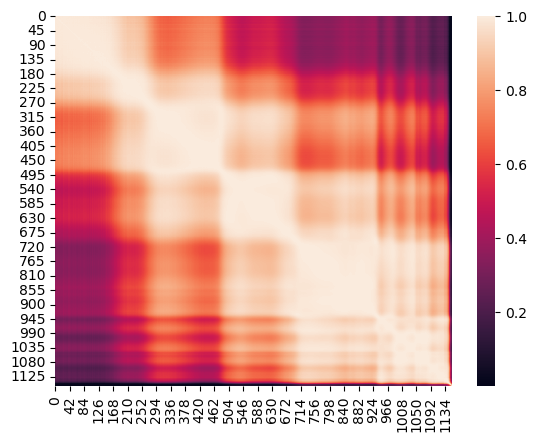

In [ ]:
sns.heatmap(np.corrcoef(Xcal, rowvar=False)**2)

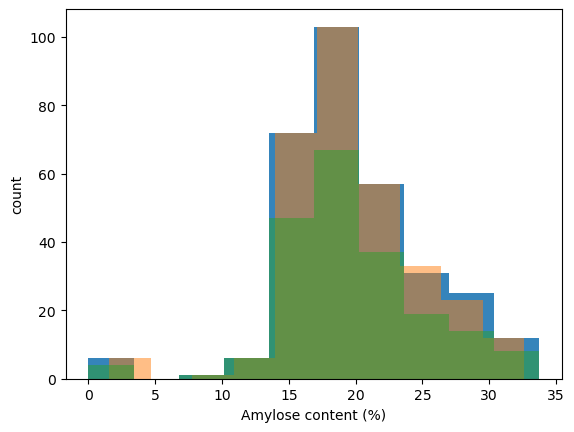

In [ ]:
plt.hist(iodine['Iodine'], alpha=0.9)
plt.hist(iodine['NIR-model'], alpha=0.5)
plt.hist(ycal, alpha=0.5)

plt.xlabel('Amylose content (%)')
plt.ylabel('count')
plt.show()

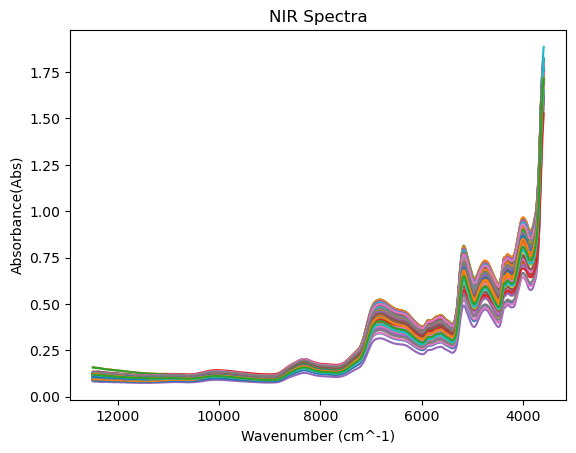

In [ ]:
for i in range(len(Xcal)):
    plt.plot(xaxis, Xcal[i,:])

plt.xlabel('Wavenumber (cm^-1)')
plt.ylabel('Absorbance(Abs)')
plt.title('NIR Spectra')
plt.gca().invert_xaxis()
plt.show()

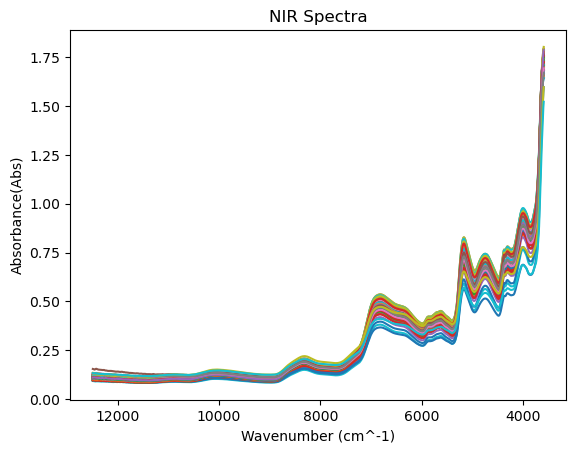

In [ ]:
for i in range(len(Xtest)):
    plt.plot(xaxis, Xtest[i,:])

plt.xlabel('Wavenumber (cm^-1)')
plt.ylabel('Absorbance(Abs)')
plt.title('NIR Spectra')
plt.gca().invert_xaxis()
plt.show()

In [ ]:
def preprocess_msc(x):

    x = (x.T - np.mean(x.T, axis=0)).T
    temp = []
    c = int(len(x))
    x_msc = np.zeros(x.shape)

    for i in range (x.shape[0]):
        for j in range (0, c, 10):
            temp.append(np.mean(x[j:j+10], axis=0))
            fit = np.polyfit(temp[i], x[i,:], 1, full=True)
            x_msc[i,:] = (x[i,:] - fit[0][1])/ fit[0][0]

    print('-'*50, 'msc done !')
    return (x_msc)

-------------------------------------------------- msc done !


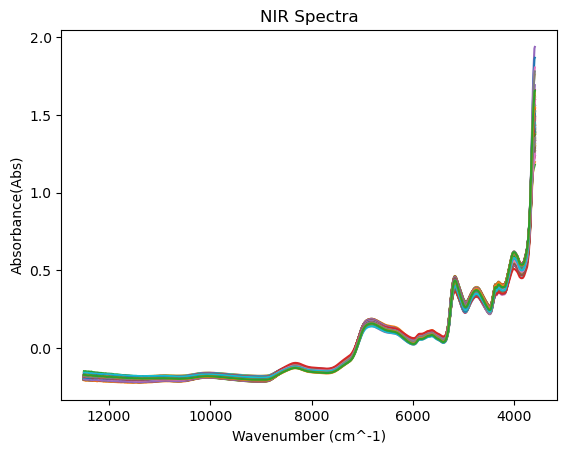

In [ ]:
x = Xcal.copy()
x_msc = preprocess_msc(x)

n = len(x_msc)

for i in range(n):
    plt.plot(xaxis, x_msc[i,:])

plt.xlabel('Wavenumber (cm^-1)')
plt.ylabel('Absorbance(Abs)')
plt.title('NIR Spectra')
plt.gca().invert_xaxis()
plt.show()

In [ ]:
def scalethis(x_train, x_test, y_train, y_test):
    # Scale x:
    scl = preprocessing.StandardScaler()
    scl.fit(x_train)
    x_train = scl.transform(x_train)
    x_test = scl.transform(x_test)

    scl = preprocessing.StandardScaler()
    scl.fit(y_train)
    y_train = scl.transform(y_train)
    y_test = scl.transform(y_test)

    print('-'*50, 'scaling done !')
    return x_train, x_test, y_train, y_test

In [ ]:
def der(x_train, x_test, dv=1):
    out={}
    n, names = 0, ['x_train', 'x_test']

    for x in [x_train, x_test]:
        c=0
        for i in range(len(x)):
            d = np.gradient(x[i,:])
            if(dv==2):
                d = np.gradient(d)
            if c==0:
                c+=1
                x_d=d
            else:
                x_d = np.vstack([x_d,d])

        out[names[n]] = x_d
        n +=1

    x_train = out['x_train']
    x_test = out['x_test']

    print('-'*50, 'derivative done !')
    return x_train, x_test

In [ ]:
def fitthis(x_train, x_test, y_train, y_test, nc=2):
    try:

        plscr = PLSRegression(n_components=nc)
        plscr.fit(x_train, y_train)

        y_pred = plscr.predict(x_test)
        mse = metrics.mean_squared_error(y_test, y_pred)
        r2 = metrics.r2_score(y_test, y_pred)

        return mse, r2

    except:
        pass

In [ ]:
x_train = Xcal.copy()
y_train = ycal.copy()
x_test = Xtest.copy()
y_test = ytest.copy()

cut = .22
x_train[x_train <= cut] = 0
x_test[x_test <= cut] = 0

x_train = preprocess_msc(x_train)
x_test = preprocess_msc(x_test)

x_train, x_test, y_train, y_test = scalethis(x_train, x_test, y_train, y_test)

maxr2 = 0
bestnc = 0
the_mse = 0

for nc in range(2, 100):

    try:
        mse, r2 = fitthis(x_train, x_test, y_train, y_test, nc=nc)
        if(r2 > maxr2):
            maxr2 = r2
            bestnc = nc
            the_mse = mse

    except:
        pass

print('n_components:', bestnc)
print("mse:", mse)
print("r2:", maxr2)

-------------------------------------------------- msc done !
-------------------------------------------------- msc done !
-------------------------------------------------- scaling done !
n_components: 46
mse: 0.39123265442236504
r2: 0.85882171133891


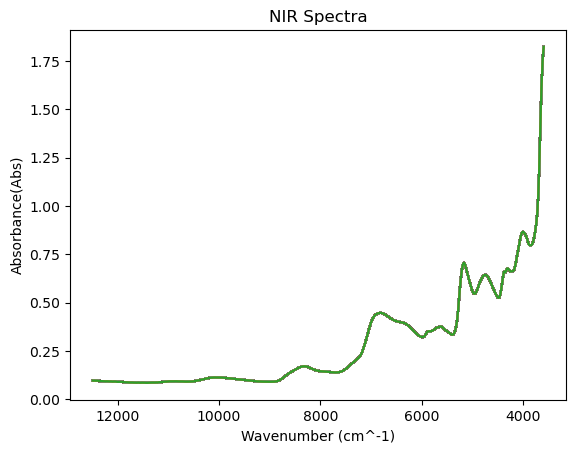

In [ ]:
for i in range(len(Xcal)):
    plt.plot(xaxis, Xcal[0,:])

plt.xlabel('Wavenumber (cm^-1)')
plt.ylabel('Absorbance(Abs)')
plt.title('NIR Spectra')
plt.gca().invert_xaxis()
plt.show()

0.13741267314550648


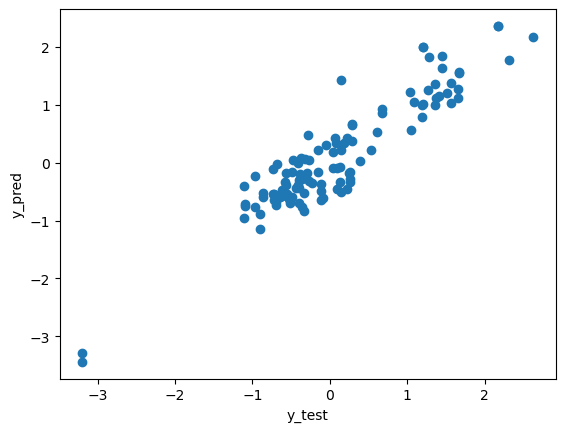

In [ ]:
plscr = PLSRegression(n_components=bestnc)
plscr.fit(x_train, y_train)

y_pred = plscr.predict(x_test)
mse = metrics.mean_squared_error(y_test, y_pred)
print(mse)

plt.scatter(y_test, y_pred)
plt.xlabel('y_test')
plt.ylabel('y_pred')
plt.show()

mse: 7.233201767017883e+16
r2: -7.431418250095736e+16


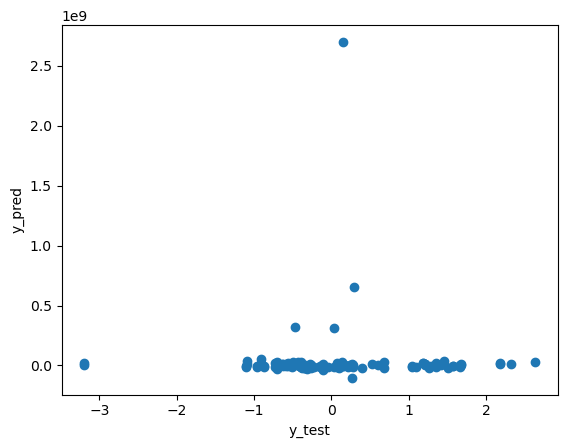

In [ ]:
reg = linear_model.LinearRegression()
reg.fit(x_train, y_train)
y_pred = reg.predict(x_test)

mse = metrics.mean_squared_error(y_test,y_pred)
r2 = metrics.r2_score(y_test, y_pred)

print('mse:', mse)
print('r2:', r2)

plt.scatter(y_test, y_pred)
plt.xlabel('y_test')
plt.ylabel('y_pred')
plt.show()